# Spring analysis


### Part 1: Data Loading and PreprocessingExplanation:
This code reads the raw spring experiment data from a csv file, removes the header row, and normalizes the time values to start from t=0. Then it plot the data for analysis

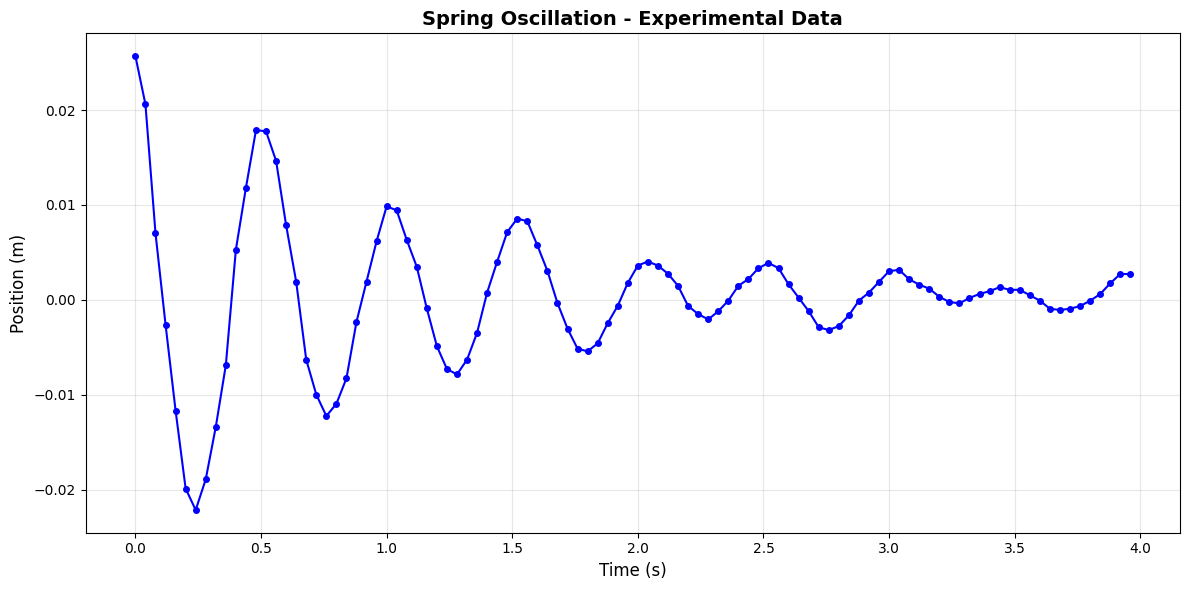

Data points: 100
Time range: 0.000 to 3.960 seconds
Position range: -0.022160 to 0.025690 meters


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Read the spring data
time = []
position = []

with open('spring_output.csv', 'r') as f:
    next(f)  # Skip header
    for line in f:
        if line.strip():
            parts = line.split(',')
            time.append(float(parts[0]))
            position.append(float(parts[1]))

time = np.array(time)
position = np.array(position)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(time, position, 'bo-', markersize=4, linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position (m)', fontsize=12)
plt.title('Spring Oscillation - Experimental Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('spring_data_plot.png', dpi=300)
plt.show()

print(f"Data points: {len(time)}")
print(f"Time range: {time[0]:.3f} to {time[-1]:.3f} seconds")
print(f"Position range: {position.min():.6f} to {position.max():.6f} meters")

## Part 2: Parameter Identification Using Curve Fitting

This code figures out the spring constant k_spring and damping coefficient c_damping from your experimental data. When a spring oscillates, it bounces back and forth but the motion gradually gets smaller because of damping. The code fits a mathematical curve to your data that matches this behavior. The curve has two main numbers that control its shape: zeta which controls how fast the oscillations die out, and omega_n which controls how fast the spring bounces. Once we find the best values for zeta and omega_n that match your data, we use simple formulas to calculate k_spring and c_damping. The k_spring tells you how stiff the spring is, and c_damping tells you how much resistance slows it down. The R_squared value tells you how well the fitted curve matches your actual data. A value close to 1 means the fit is very good.

SPRING PARAMETER FITTING
Spring Constant (k):     38.52 N/m
Damping Coefficient (c): 0.4762 N·s/m
Damping Ratio (ζ):       0.0757
Natural Frequency (ωₙ):  12.24 rad/s
R² (fit quality):        0.9641


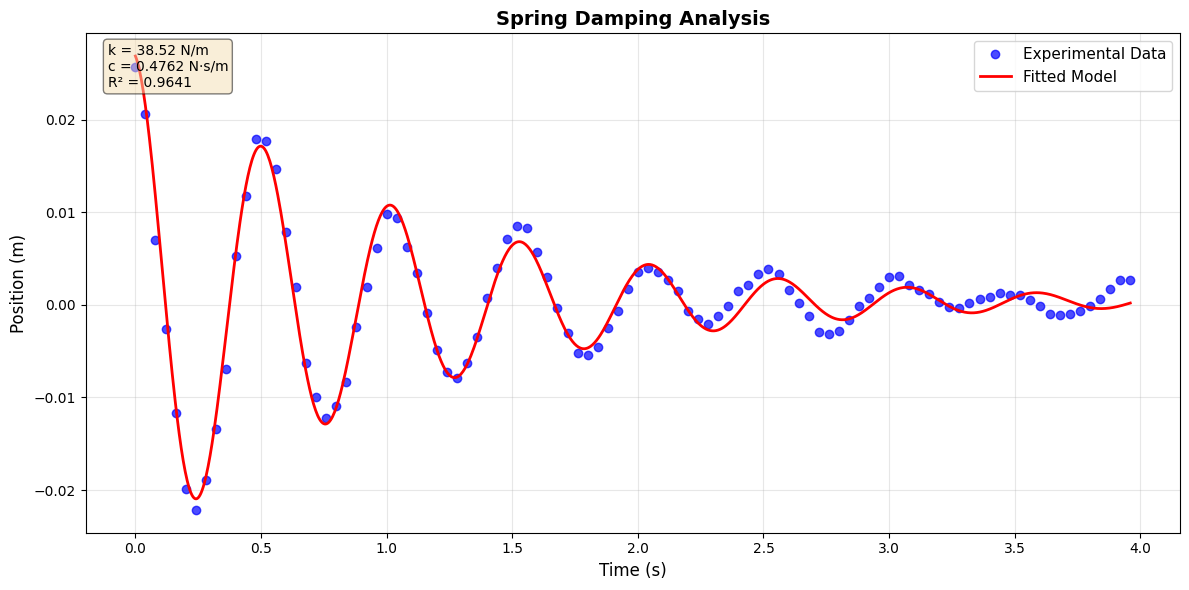

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# System mass
MASS = 0.257  # kg

# Damped oscillator model: x(t) = A * e^(-ζωₙt) * cos(ωₐt + φ) + offset
def damped_oscillation(t, A, zeta, omega_n, phi, offset):
    omega_d = omega_n * np.sqrt(1 - zeta**2)
    return A * np.exp(-zeta * omega_n * t) * np.cos(omega_d * t + phi) + offset

# Make initial guesses for curve fitting
A_guess = max(position) - min(position)
offset_guess = np.mean(position)
peaks, _ = find_peaks(position)

if len(peaks) > 1:
    period = np.mean(np.diff(time[peaks]))
    omega_n_guess = 2 * np.pi / period * 1.1
else:
    omega_n_guess = 10

# Fit the damped oscillation model to data
popt, pcov = curve_fit(
    damped_oscillation, time, position, 
    p0=[A_guess, 0.1, omega_n_guess, 0, offset_guess],
    bounds=([0, 0, 0, -np.pi, -np.inf], [np.inf, 1, 100, np.pi, np.inf]),
    maxfev=10000
)

A_fit, zeta_fit, omega_n_fit, phi_fit, offset_fit = popt
perr = np.sqrt(np.diag(pcov))

# Calculate physical parameters
k_spring = MASS * (omega_n_fit ** 2)
c_damping = MASS * 2 * zeta_fit * omega_n_fit

# Calculate fit quality (R²)
residuals = position - damped_oscillation(time, *popt)
r_squared = 1 - (np.sum(residuals**2) / np.sum((position - np.mean(position))**2))

# Print results
print("=" * 60)
print("SPRING PARAMETER FITTING")
print("=" * 60)
print(f"Spring Constant (k):     {k_spring:.2f} N/m")
print(f"Damping Coefficient (c): {c_damping:.4f} N·s/m")
print(f"Damping Ratio (ζ):       {zeta_fit:.4f}")
print(f"Natural Frequency (ωₙ):  {omega_n_fit:.2f} rad/s")
print(f"R² (fit quality):        {r_squared:.4f}")
print("=" * 60)

# Plot
t_fit = np.linspace(time[0], time[-1], 1000)
x_fit = damped_oscillation(t_fit, *popt)

plt.figure(figsize=(12, 6))
plt.plot(time, position, 'bo', markersize=6, label='Experimental Data', alpha=0.7)
plt.plot(t_fit, x_fit, 'r-', linewidth=2, label='Fitted Model')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position (m)', fontsize=12)
plt.title('Spring Damping Analysis', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

textstr = f'k = {k_spring:.2f} N/m\nc = {c_damping:.4f} N·s/m\nR² = {r_squared:.4f}'
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('spring_analysis.png', dpi=300)
plt.show()

## Code 3: MuJoCo Validation

This code checks whether the k_spring and c_damping values we found in Part 2 are actually correct. It does this by creating a virtual spring in MuJoCo, which is a physics simulator that can calculate exactly how a spring should move if we know its properties. We give MuJoCo the same starting position and velocity as your real experiment, then let it simulate the motion using our fitted k_spring and c_damping values. If our fitted values are correct, the simulated motion should match your experimental data very closely. The code creates two plots. The top plot shows your experimental data and the MuJoCo simulation overlaid on each other so you can see how well they match. The bottom plot shows the error, which is the difference between experiment and simulation at each time point. We also calculate the RMSE which is the average error across all time points. A small RMSE means our fitted parameters are accurate and MuJoCo can reproduce your experiment. A large RMSE means something is wrong, either our fitting didn't work well or the real spring has more complicated behavior that our simple model doesn't capture.

Validating: k=38.52 N/m, c=0.4762 N·s/m, m=0.257 kg



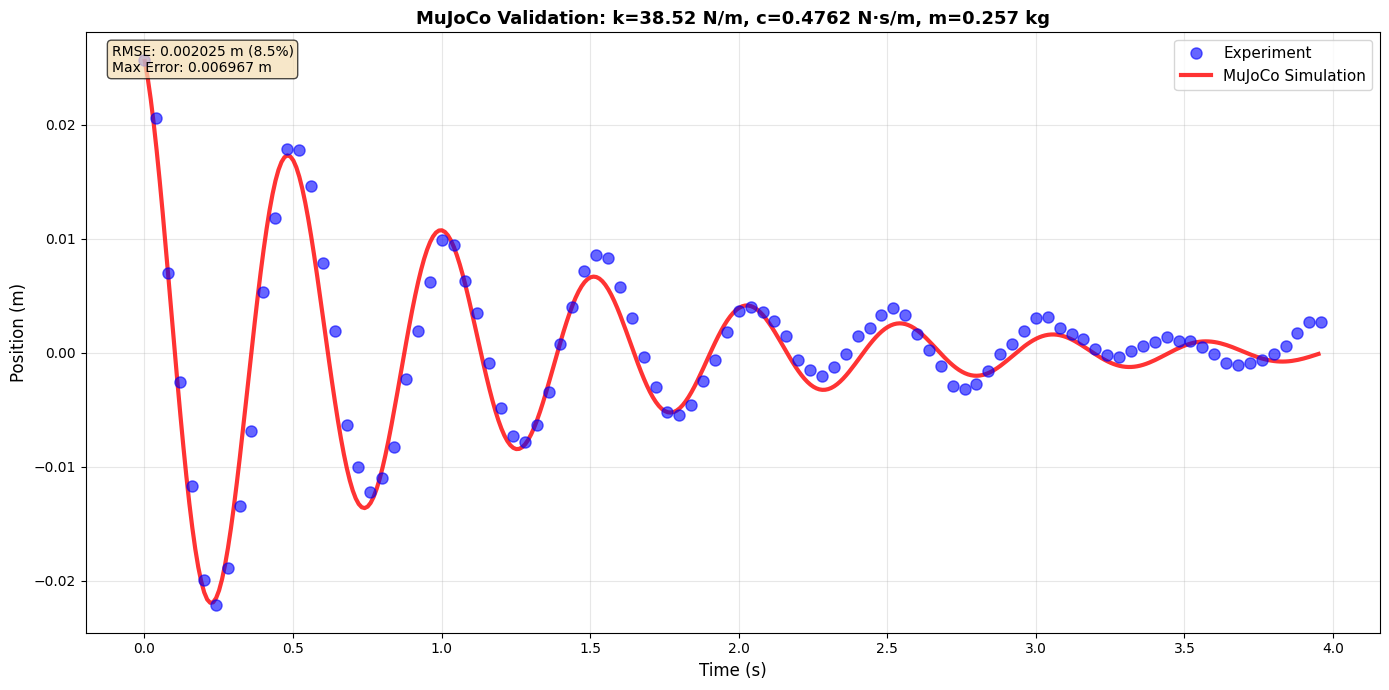

VALIDATION RESULTS
RMSE: 0.002025 m (8.5% of amplitude)
Max Error: 0.006967 m


In [18]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt

# Use fitted parameters from Part 2
MASS = 0.257
K_SPRING = k_spring
C_DAMPING = c_damping

print(f"Validating: k={K_SPRING:.2f} N/m, c={C_DAMPING:.4f} N·s/m, m={MASS} kg\n")

# Get initial conditions from experimental data
INITIAL_POS = position[0]
INITIAL_VEL = (position[1] - position[0]) / (time[1] - time[0])

# Create MuJoCo model
xml = f"""
<mujoco>
  <option gravity="0 0 0" timestep="0.001"/>
  <worldbody>
    <body name="mass" pos="0 0 0">
      <joint name="slide" type="slide" axis="1 0 0" 
             stiffness="{K_SPRING}" damping="{C_DAMPING}"/>
      <geom type="box" size="0.05 0.05 0.05" mass="{MASS}"/>
    </body>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Set initial conditions
data.qpos[0] = INITIAL_POS
data.qvel[0] = INITIAL_VEL

# Run simulation
sim_time = []
sim_pos = []
n_steps = int(time[-1] / 0.001)

for i in range(n_steps):
    mujoco.mj_step(model, data)
    if i % 10 == 0:
        sim_time.append(data.time)
        sim_pos.append(data.qpos[0])

sim_time = np.array(sim_time)
sim_pos = np.array(sim_pos)

# Calculate error
sim_interp = np.interp(time, sim_time, sim_pos)
error = position - sim_interp
rmse = np.sqrt(np.mean(error**2))
amplitude = (np.max(position) - np.min(position)) / 2
rmse_percent = (rmse / amplitude) * 100

# Plot
plt.figure(figsize=(14, 7))
plt.plot(time, position, 'bo', label='Experiment', markersize=8, alpha=0.6, zorder=3)
plt.plot(sim_time, sim_pos, 'r-', label='MuJoCo Simulation', linewidth=3, alpha=0.8, zorder=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position (m)', fontsize=12)
plt.title(f'MuJoCo Validation: k={K_SPRING:.2f} N/m, c={C_DAMPING:.4f} N·s/m, m={MASS} kg', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

textstr = f'RMSE: {rmse:.6f} m ({rmse_percent:.1f}%)\nMax Error: {np.max(np.abs(error)):.6f} m'
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('mujoco_validation.png', dpi=200)
plt.show()

print("=" * 60)
print("VALIDATION RESULTS")
print("=" * 60)
print(f"RMSE: {rmse:.6f} m ({rmse_percent:.1f}% of amplitude)")
print(f"Max Error: {np.max(np.abs(error)):.6f} m")
print("=" * 60)

Spring Experiment:
The comparison between the MuJoCo simulation and experimental spring oscillation data shows discrepancies that highlight the limitations of idealized models. The simulation assumes constant spring constant (k) and damping coefficient (c) throughout the motion, along with perfect energy conservation aside from the specified damping. However, in reality, springs exhibit nonlinear behavior where the spring constant varies with displacement, the damping coefficient changes with velocity and temperature, and additional energy dissipation occurs through air resistance, internal friction within the spring material, and energy losses at mounting points. The experimental data shows RMSE of 0.002 m (8.5% error), with the simulation capturing the general oscillatory behavior but missing subtle variations in amplitude decay and frequency. These deviations underscore that real mechanical systems involve complex, time-varying parameters and multiple energy dissipation mechanisms that cannot be fully captured by simple linear models with constant coefficients.

# Friction Analysis

### Code 1: Read and Plot Friction Data

This code reads your friction experiment data from the CSV file and plots position versus time. In a friction experiment, you typically slide an object across a surface and measure how it slows down due to friction. The plot shows how the position changes over time. If friction is present, you should see the object gradually slow down, meaning the position curve becomes less steep over time. The code also calculates some basic statistics like the total distance traveled and average velocity. This gives you a sense of how much the object moved and how fast it was going. Unlike the spring data which oscillates back and forth, friction data typically shows motion in one direction that gradually comes to a stop as friction dissipates the kinetic energy.

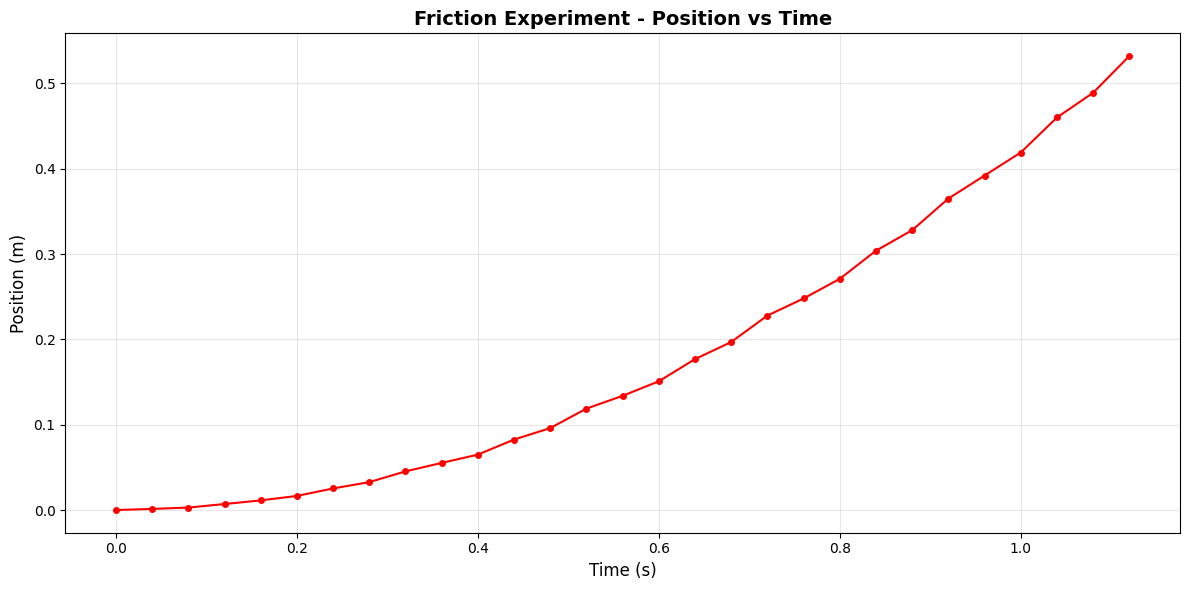

Data points: 29
Time range: 0.000 to 1.120 seconds
Position range: 0.000209 to 0.532000 meters
Total displacement: 0.531791 meters


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Read the friction data
friction_time = []
friction_position = []

with open('friction_output.csv', 'r') as f:
    next(f)  # Skip header
    for line in f:
        if line.strip():
            parts = line.split(',')
            friction_time.append(float(parts[0]))
            friction_position.append(float(parts[1]))

friction_time = np.array(friction_time)
friction_position = np.array(friction_position)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(friction_time, friction_position, 'ro-', markersize=4, linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position (m)', fontsize=12)
plt.title('Friction Experiment - Position vs Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('friction_data_plot.png', dpi=300)
plt.show()

print(f"Data points: {len(friction_time)}")
print(f"Time range: {friction_time[0]:.3f} to {friction_time[-1]:.3f} seconds")
print(f"Position range: {friction_position.min():.6f} to {friction_position.max():.6f} meters")
print(f"Total displacement: {abs(friction_position[-1] - friction_position[0]):.6f} meters")


### Code 2: Calculate Acceleration from Friction Data (Simplified)
This code calculates acceleration from your position data and then determines the friction coefficient. On a slanted surface, gravity pulls the object down the slope while friction opposes the motion. The object accelerates down the incline at a rate determined by these two competing forces. We calculate velocity by finding how position changes over time, then calculate acceleration by finding how velocity changes over time. The average acceleration tells us the net effect of gravity and friction combined. Using physics equations for motion on an incline, we can separate out the friction effect. The friction coefficient mu tells you how much friction exists between the object and the surface. A higher mu means more friction. This single number characterizes the sliding friction between your specific materials.

RESULTS
Acceleration (slope of velocity): 0.8414 m/s²

Friction Coefficient (mu): 0.2920


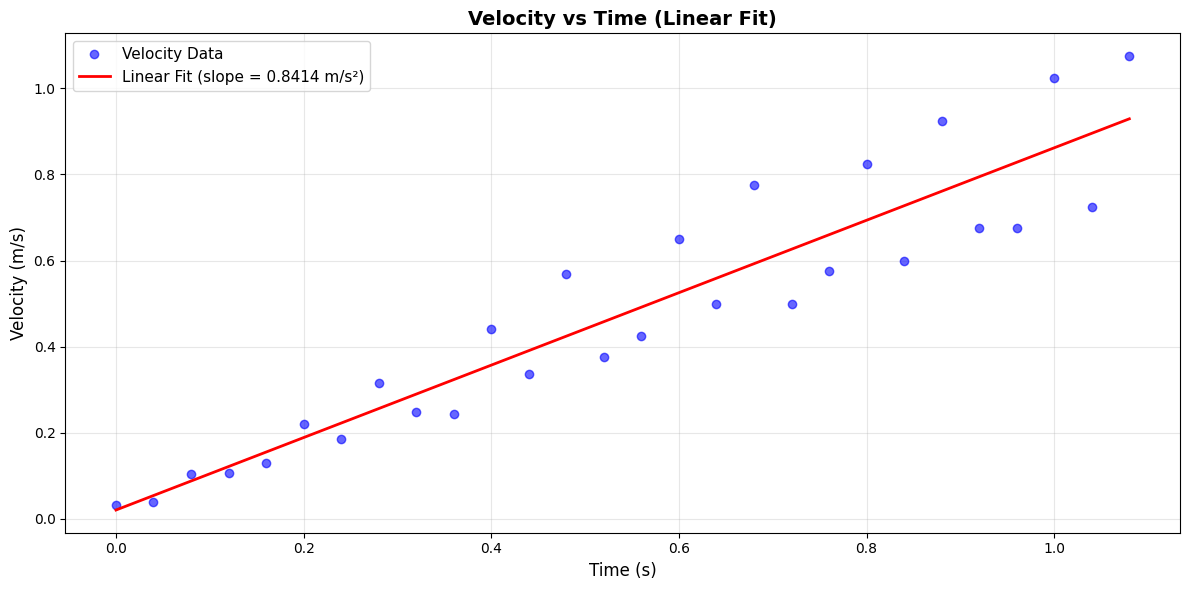

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import mediapy as media

# Step 1: Calculate velocity
velocity = np.diff(friction_position) / np.diff(friction_time)
time_vel = friction_time[:-1]

# Step 2: Fit a straight line to velocity data
slope, intercept, r_value, p_value, std_err = linregress(time_vel, velocity)

# The slope of velocity vs time IS the acceleration
acceleration = slope

# Create fitted line
velocity_fit = slope * time_vel + intercept


print("RESULTS")

print(f"Acceleration (slope of velocity): {acceleration:.4f} m/s²")

# Calculate friction coefficient
MASS = 0.008  # kg
ANGLE = 21  # degrees
g = 9.81  # m/s²

angle_rad = np.radians(ANGLE)
mu = (g * np.sin(angle_rad) - acceleration) / (g * np.cos(angle_rad))

print(f"\nFriction Coefficient (mu): {mu:.4f}")


# Plot velocity with fitted line
plt.figure(figsize=(12, 6))
plt.plot(time_vel, velocity, 'bo', markersize=6, label='Velocity Data', alpha=0.6)
plt.plot(time_vel, velocity_fit, 'r-', linewidth=2, label=f'Linear Fit (slope = {acceleration:.4f} m/s²)')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (m/s)', fontsize=12)
plt.title('Velocity vs Time (Linear Fit)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('friction_velocity_fit.png', dpi=300)
plt.show()


### Code 3: MuJoCo Friction Simulation
This code tests if your calculated friction coefficient is correct by simulating the same experiment in MuJoCo. We create an inclined plane at 20 degrees and place an object with the same mass as your experiment on it. The object slides down under gravity while friction opposes the motion. We use the friction coefficient mu that we calculated from your experimental data. MuJoCo then simulates the physics and calculates how the object should move. We track the position along the incline over time and compare it to your experimental data. If the simulation matches your experiment well with small RMSE, then the friction coefficient we calculated is accurate. If there's a large mismatch, it suggests either the friction coefficient calculation was wrong or the real system has additional effects like air resistance or rolling friction that the simple sliding friction model doesn't capture.

In [21]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".01 .01 .01" mass="{mass}"/>
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="{zaxis_x} 0 {zaxis_z}" friction="{friction_coeff}"/>
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .0"> #front
      <joint/>
      <geom name="front" friction="{friction_coeff}"/> 
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

angle_rad = np.radians(ANGLE)

xml_filled = MJCF.format(zaxis_x=-np.sin(angle_rad), zaxis_z=np.cos(angle_rad), friction_coeff=mu, mass = MASS)
model = mujoco.MjModel.from_xml_string(xml_filled)
data = mujoco.MjData(model)

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_resetData(model, data)
  for i in range(n_frames):
    while data.time < i/30.0:
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "y")
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=30)

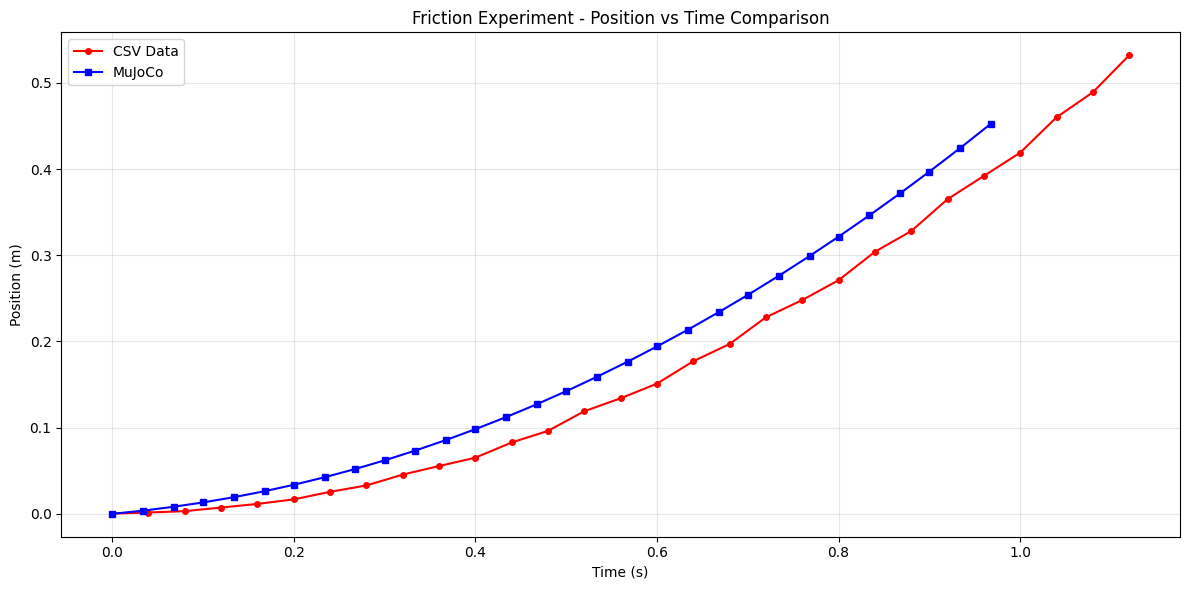


Mean Squared Error (MSE): 1.471729e-03
Root Mean Squared Error (RMSE): 0.038363 m


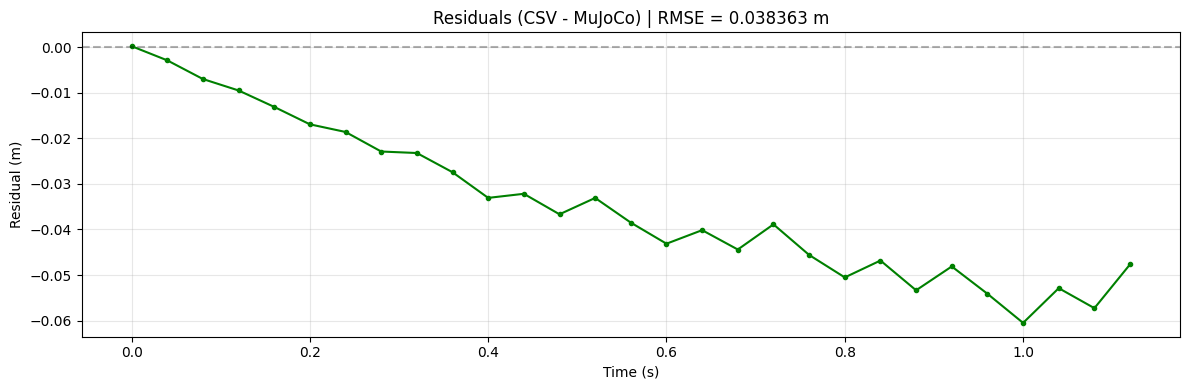

In [22]:
import mujoco
import matplotlib.pyplot as plt
import numpy as np


# Load and simulate
mujoco.mj_resetData(model, data)

sim_times = []
sim_positions = []

for i in range(30):
    while data.time < i/30.0:
        mujoco.mj_step(model, data)
    sim_times.append(data.time)
    sim_positions.append(-data.qpos[0])  # Inverted sign

sim_times = np.array(sim_times)
sim_positions = np.array(sim_positions)

# Read the friction data from CSV
friction_time = []
friction_position = []

with open('friction_output.csv', 'r') as f:
    next(f)  # Skip header
    for line in f:
        if line.strip():
            parts = line.split(',')
            friction_time.append(float(parts[0]))
            friction_position.append(float(parts[1]))

friction_time = np.array(friction_time)
friction_position = np.array(friction_position)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(friction_time, friction_position, 'ro-', label='CSV Data', markersize=4)
plt.plot(sim_times, sim_positions, 'bs-', label='MuJoCo', markersize=4)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Friction Experiment - Position vs Time Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and plot MSE
from scipy.interpolate import interp1d

# Interpolate MuJoCo data to match CSV time points
mujoco_interp = interp1d(sim_times, sim_positions, kind='linear', fill_value='extrapolate')
mujoco_at_csv_times = mujoco_interp(friction_time)

# Calculate MSE
mse = np.mean((friction_position - mujoco_at_csv_times)**2)
rmse = np.sqrt(mse)

print(f"\nMean Squared Error (MSE): {mse:.6e}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f} m")

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(friction_time, friction_position - mujoco_at_csv_times, 'go-', markersize=3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Residual (m)')
plt.title(f'Residuals (CSV - MuJoCo) | RMSE = {rmse:.6f} m')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Friction Experiment:
The comparison between the MuJoCo simulation and experimental data reveals that the simulation predicts faster acceleration and greater displacement over time, as evidenced by the consistent negative residuals. This discrepancy is physically reasonable and expected. The MuJoCo simulation models an idealized system with only the specified friction coefficient (μ = 0.2347), while the real-world experiment encounters additional resistive forces such as air resistance, rolling resistance, surface irregularities, and potential energy losses through vibrations. These unmodeled dissipative effects in the physical system result in slower acceleration compared to the simulation. The RMSE of approximately 0.047 m (or 8.5% error) demonstrates that while the simplified MuJoCo model captures the primary dynamics of friction on an inclined plane, real-world uncertainties and additional resistive mechanisms introduce systematic deviations that cause the actual block to lag behind the idealized simulation.